In [66]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [21]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
# Declaring base
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [23]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [28]:
# Find the most recent date in the data set.
mostRecentDate = session.execute("SELECT MAX(date) FROM measurement;")

for date in mostRecentDate:
    print(f"most recent date in dataset: {date}")

most recent date in dataset: ('2017-08-23',)


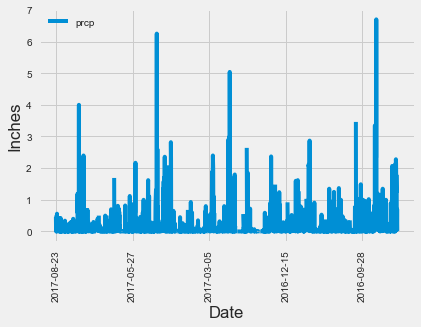

In [69]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Perform a query to retrieve the data and precipitation scores
dataPrecipitationScores = session.execute("SELECT * FROM measurement\
                                          WHERE date between '2016-08-23' AND '2017-08-23'; ")

#  engine.execute("SELECT * FROM measurement\
#                 WHERE date between '2016-08-23' AND '2017-08-23';").fetchall()

# Save the query results as a Pandas DataFrame and set the index to the date column
dataPrecipitationScoresDF = pd.DataFrame(dataPrecipitationScores).set_index('date')

# Sort the dataframe by date
dataPrecipitationScoresDF = dataPrecipitationScoresDF.sort_values(by='date',ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data
dataPrecipitationScoresDF.plot(y='prcp')
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [63]:
# Use Pandas to calculate the summary statistics for the precipitation data
dataPrecipitationScoresDF.describe()

,id,prcp,tobs
count,2230.000000,2021.000000,2230.000000
mean,10158.570404,0.177279,74.590583
std,5603.500203,0.461190,4.611667
min,2364.000000,0.000000,58.000000
25%,5287.250000,0.000000,72.000000
50%,8930.500000,0.020000,75.000000
75%,14750.750000,0.130000,78.000000
max,19550.000000,6.700000,87.000000


# Exploratory Station Analysis

In [73]:
# Design a query to calculate the total number stations in the dataset
numberOfStations = session.execute("SELECT COUNT(*) FROM station;")

# session.execute("SELECT * FROM station;").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()